In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_village = pd.read_csv('../../data/processed/cleaned_village-hotel-changi-by-far-east-hospitality.csv')
df_park = pd.read_csv('../../data/processed/cleaned_park-regis.csv')
df_grand = pd.read_csv('../../data/processed/cleaned_grand-mercure-sg-roxy.csv')
df_paradox = pd.read_csv('../../data/processed/cleaned_paradox-sg-merchant-court.csv')
df_crown = pd.read_csv('../../data/processed/cleaned_crowne-plaza.csv')


df_combi = pd.concat([df_village, df_park, df_grand, df_paradox, df_crown])

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.append('regis')
sw.append('roxy')
sw.append('village')
sw.append('village_hotel')
sw.append('grand_mercure')
sw.append('paradox')
sw.append('crown_plaza')
sw.append('crown')
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stemmed

In [11]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['tokens'] = df_filtered['stem_review'].apply(preprocess)

In [12]:
df_precovid = df_filtered[df_filtered['covid'] == 'PreCovid']
df_postcovid = df_filtered[df_filtered['covid'] == 'PostCovid']

In [13]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [14]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_precovid['tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.4105746535185587
The coherence score at topic 3 is 0.4045468748223493
The coherence score at topic 4 is 0.42124905108893407
The coherence score at topic 5 is 0.4290398671320174
The coherence score at topic 6 is 0.4439744419278193


In [17]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=6, id2word=pre_dict, passes=15)

In [15]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [16]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    post_ldamodel = lda(post_corpus, num_topics=i, id2word=post_dict, passes=15)
    
    postcovid_coherence = CoherenceModel(model=post_ldamodel, texts=df_postcovid['tokens'], dictionary=post_dict, coherence='c_v')
    lda_coherence = postcovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.3939368604344827
The coherence score at topic 3 is 0.38473656169125947
The coherence score at topic 4 is 0.3927816010851113
The coherence score at topic 5 is 0.3691729069639226
The coherence score at topic 6 is 0.382761731534232


In [18]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=6, id2word=post_dict, passes=15)

In [19]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_272\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


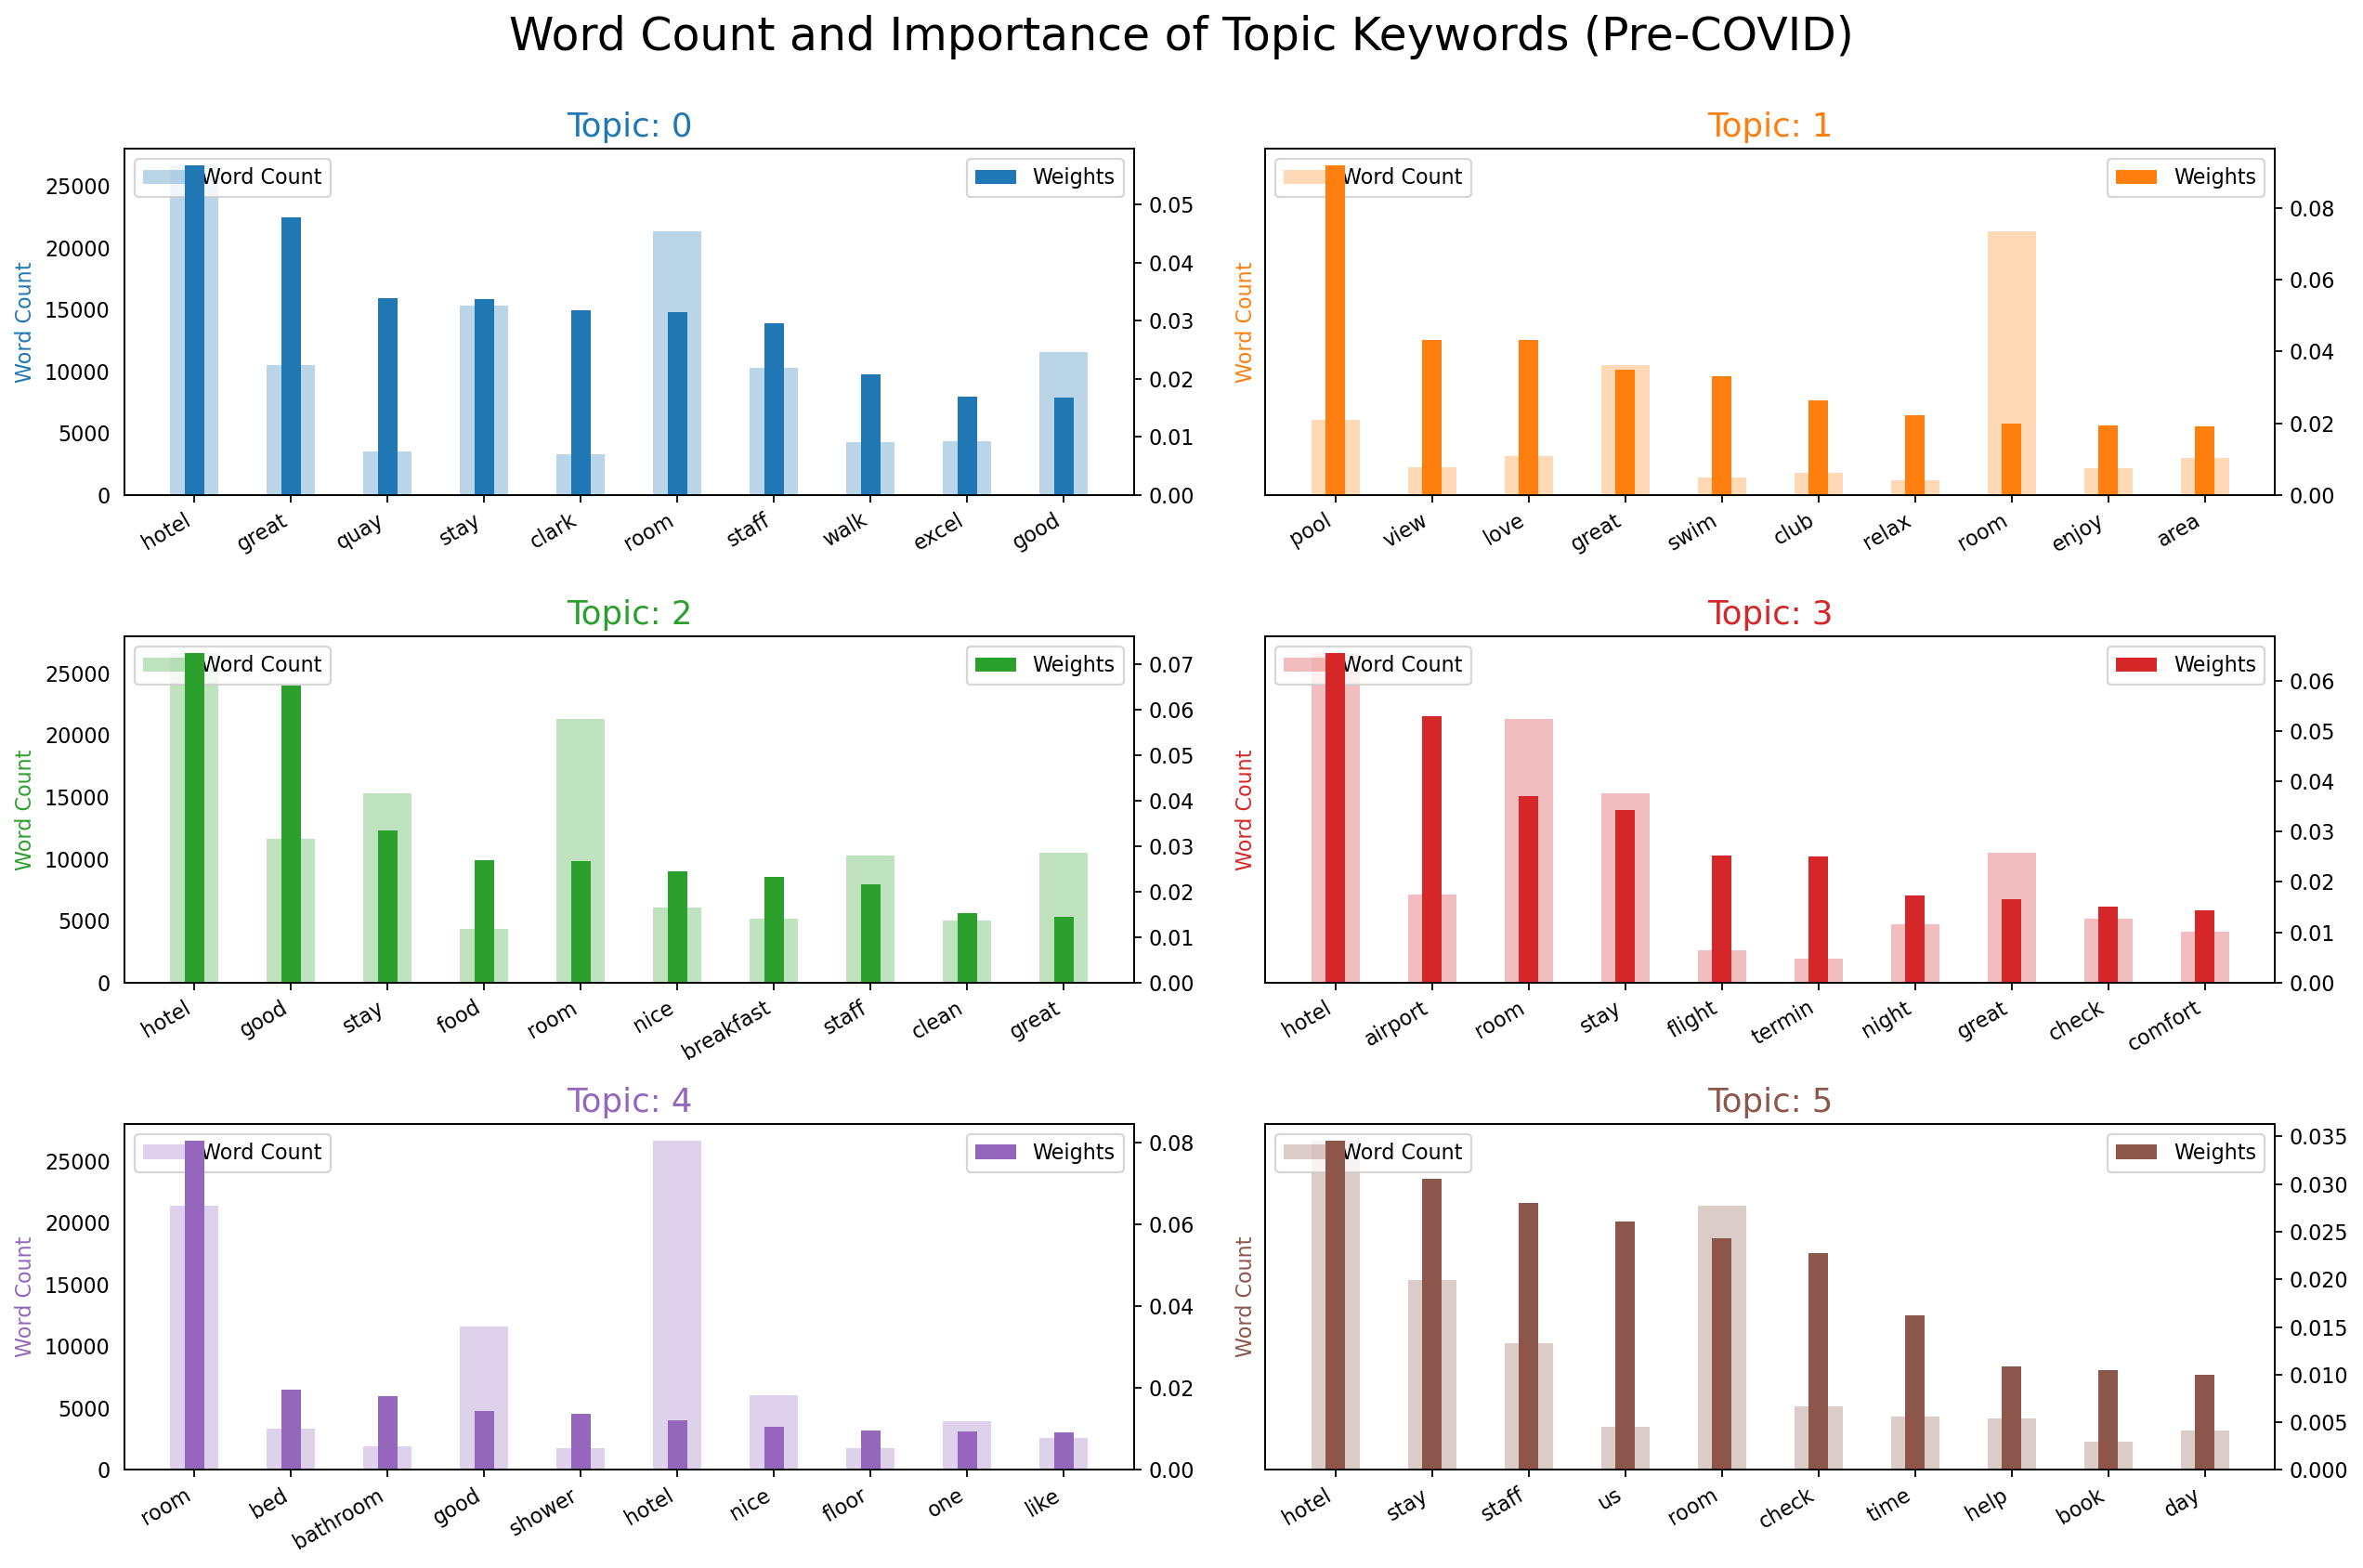

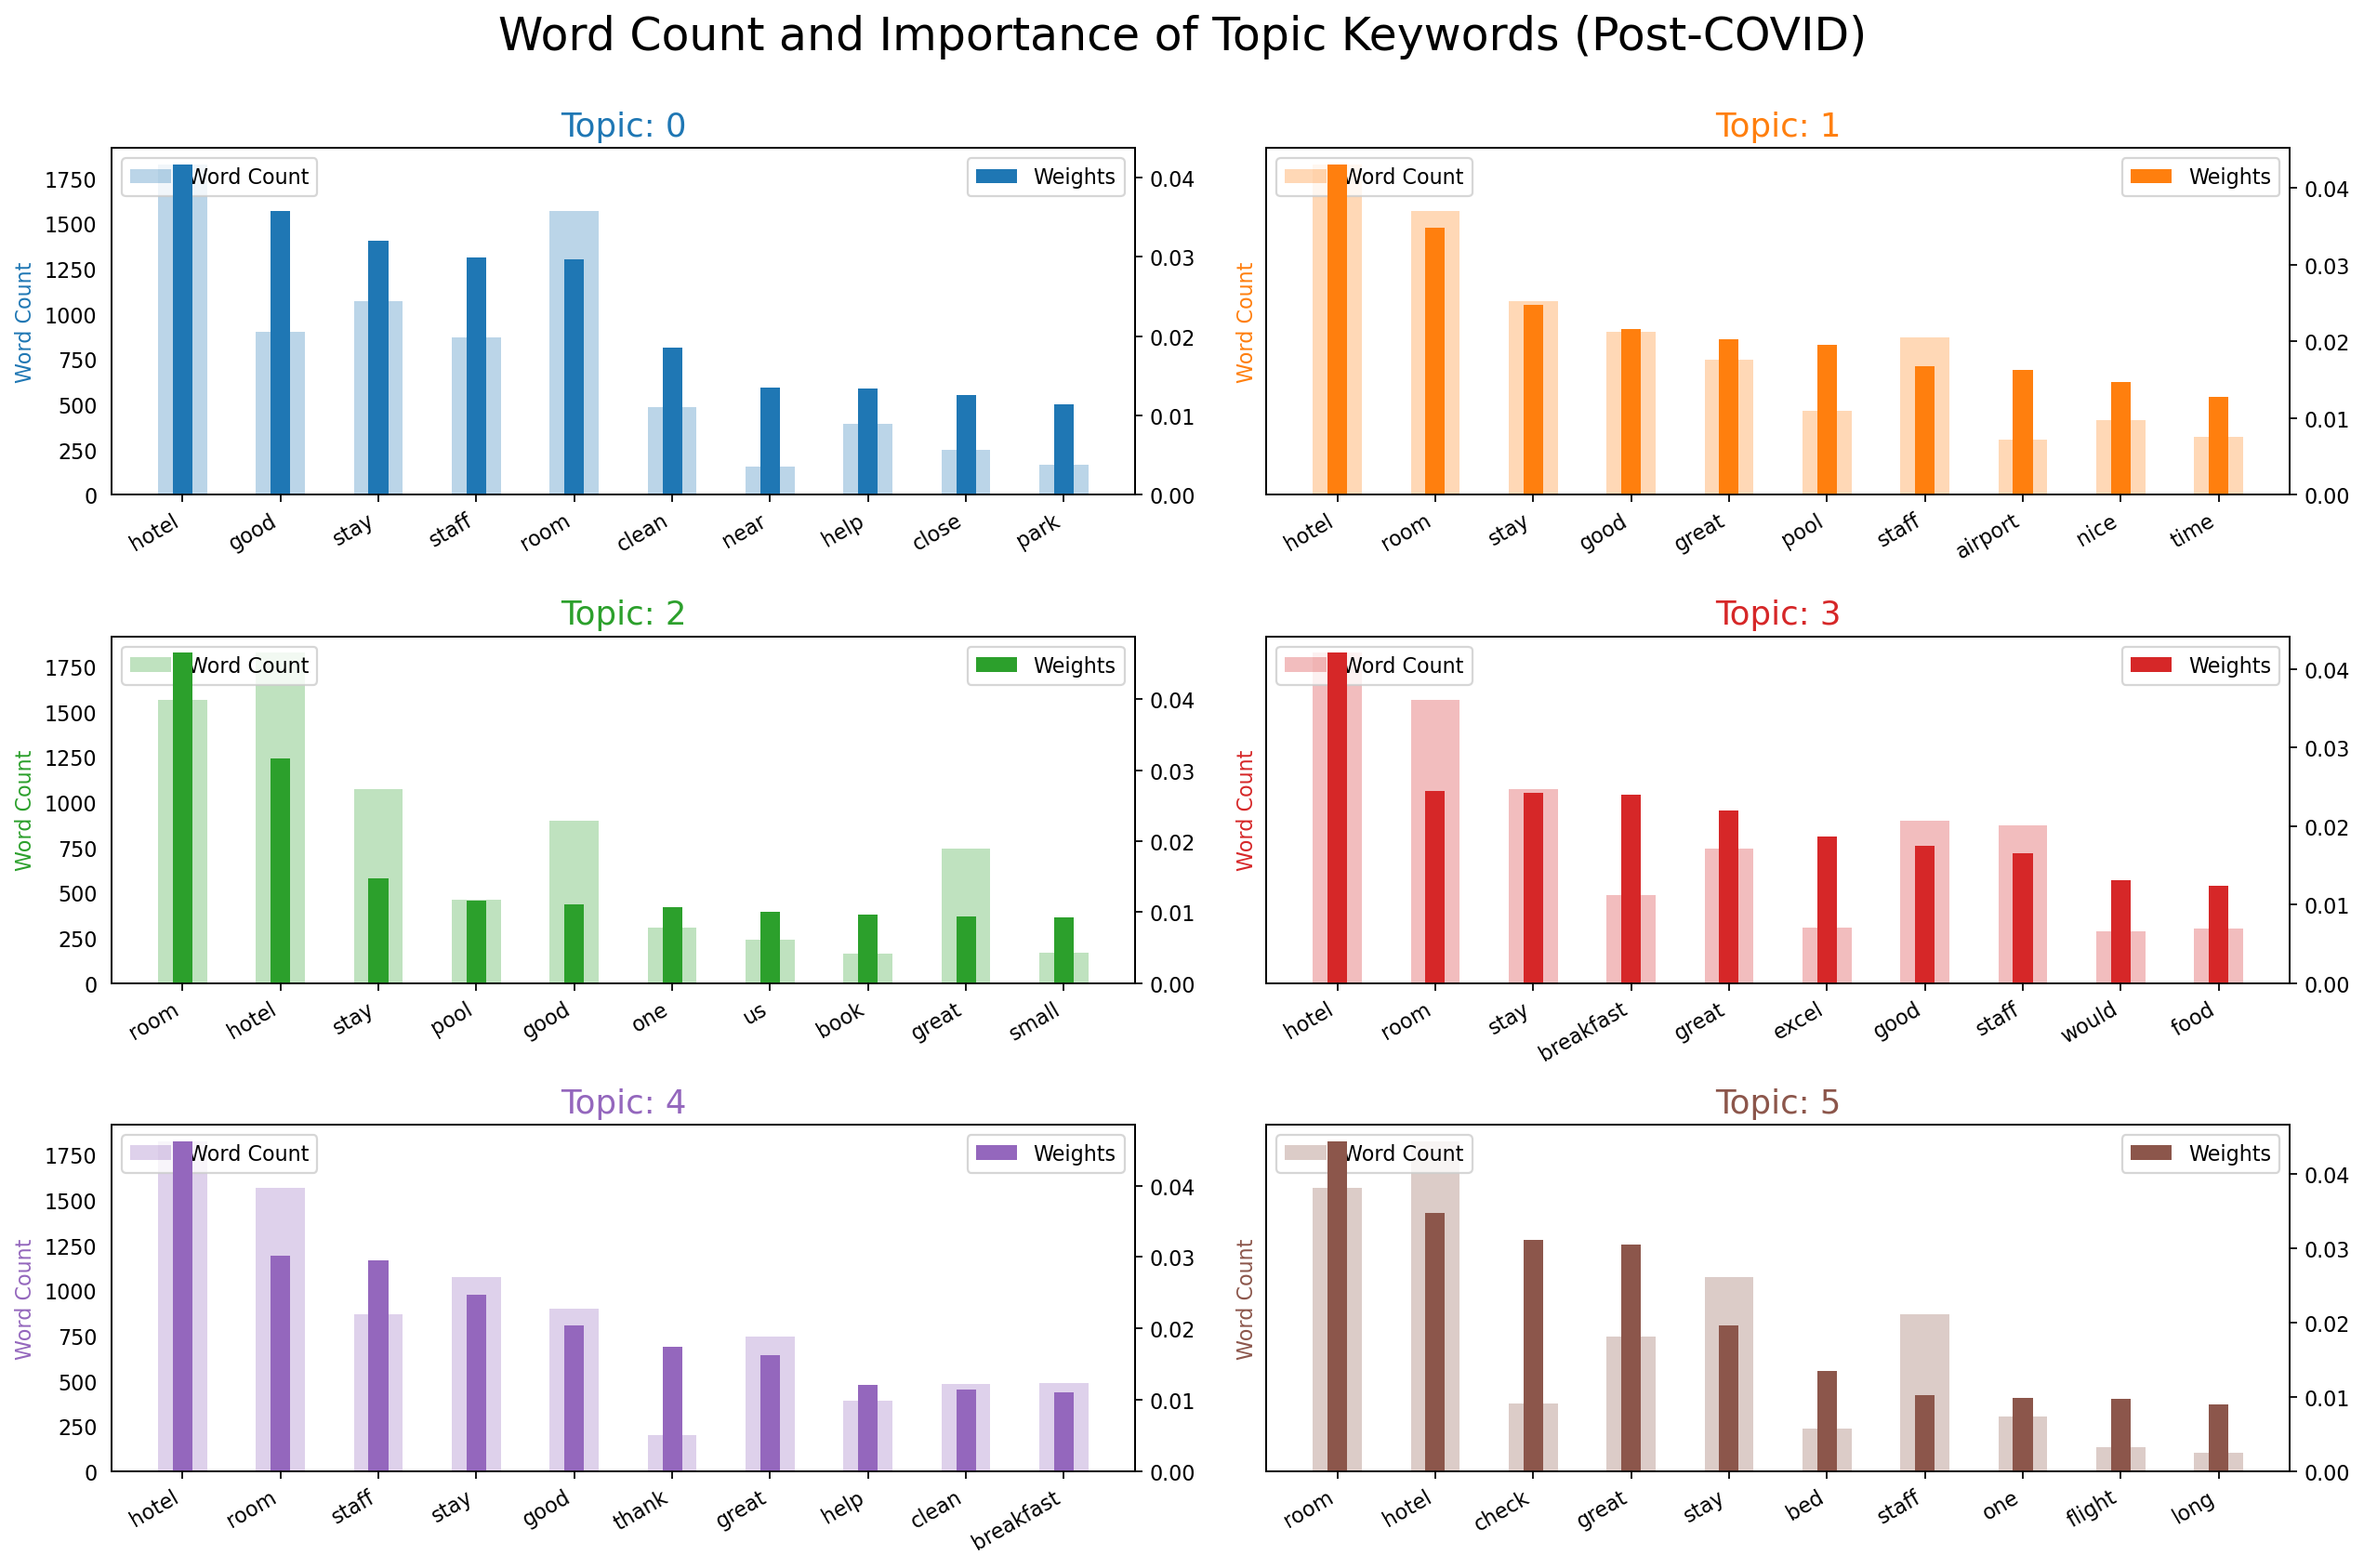

In [20]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

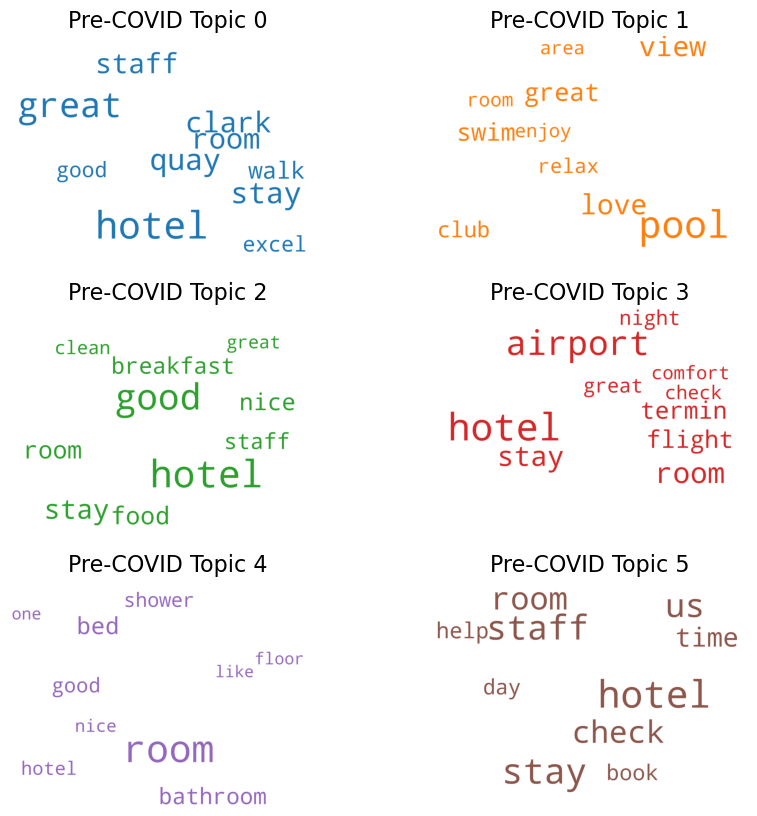

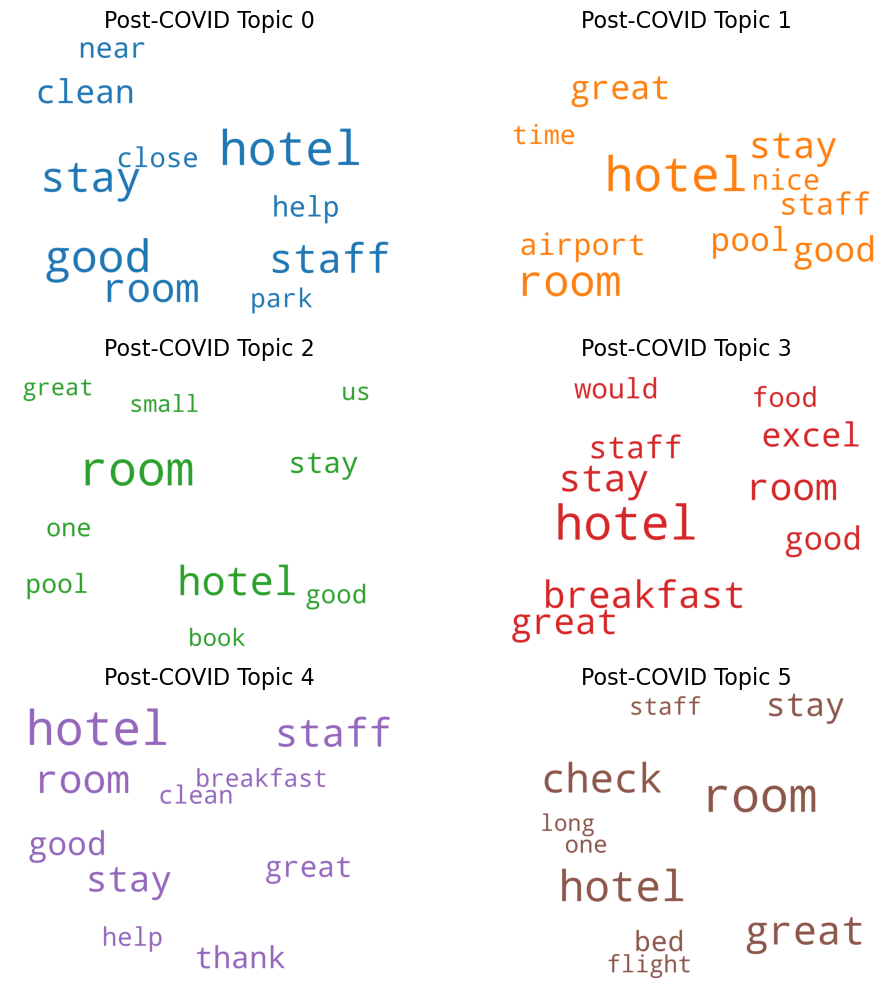

In [21]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [22]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [23]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigram

In [24]:
clean_precovid = df_precovid['stem_review'].apply(preprocess)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['stem_review'].apply(preprocess)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [25]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [26]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=6, id2word=pre_dict, passes=15)

In [27]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=6, id2word=post_dict, passes=15)

In [28]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

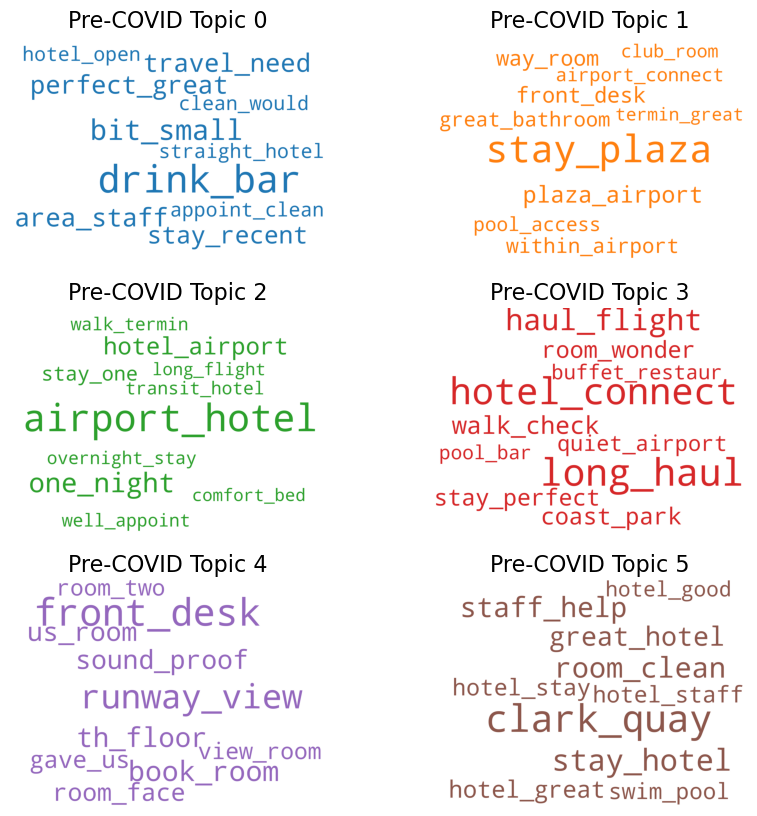

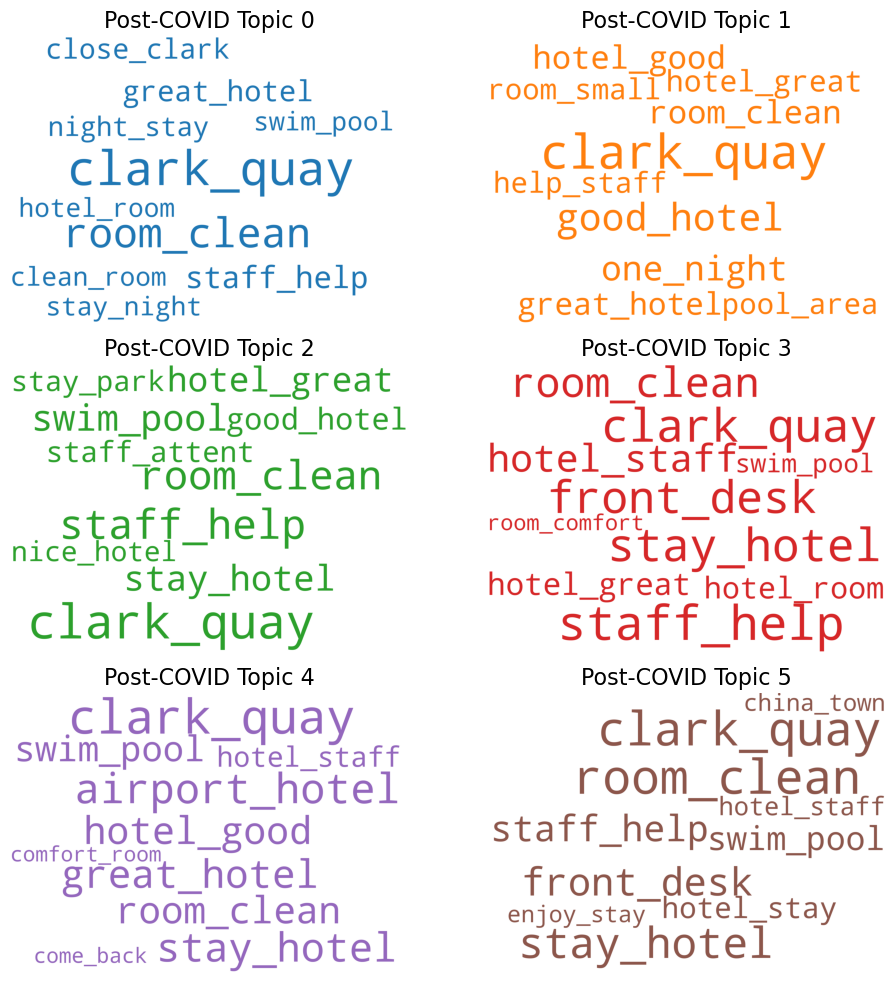

In [29]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [31]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [7]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['tokens'] = df_filtered['lem_review'].apply(preprocess)

In [8]:
df_precovid = df_filtered[df_filtered['covid'] == 'PreCovid']
df_postcovid = df_filtered[df_filtered['covid'] == 'PostCovid']

In [9]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [10]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_precovid['tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.381170992159376
The coherence score at topic 3 is 0.38311758378751987
The coherence score at topic 4 is 0.3913894644358338
The coherence score at topic 5 is 0.41140013143657866
The coherence score at topic 6 is 0.41707647049614405


In [13]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [11]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [12]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    post_ldamodel = lda(post_corpus, num_topics=i, id2word=post_dict, passes=15)
    
    postcovid_coherence = CoherenceModel(model=post_ldamodel, texts=df_postcovid['tokens'], dictionary=post_dict, coherence='c_v')
    lda_coherence = postcovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.37187733309085635
The coherence score at topic 3 is 0.36518648108050983
The coherence score at topic 4 is 0.35663645516813924
The coherence score at topic 5 is 0.38258587434396163
The coherence score at topic 6 is 0.3349798964473428


In [14]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [16]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_16424\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


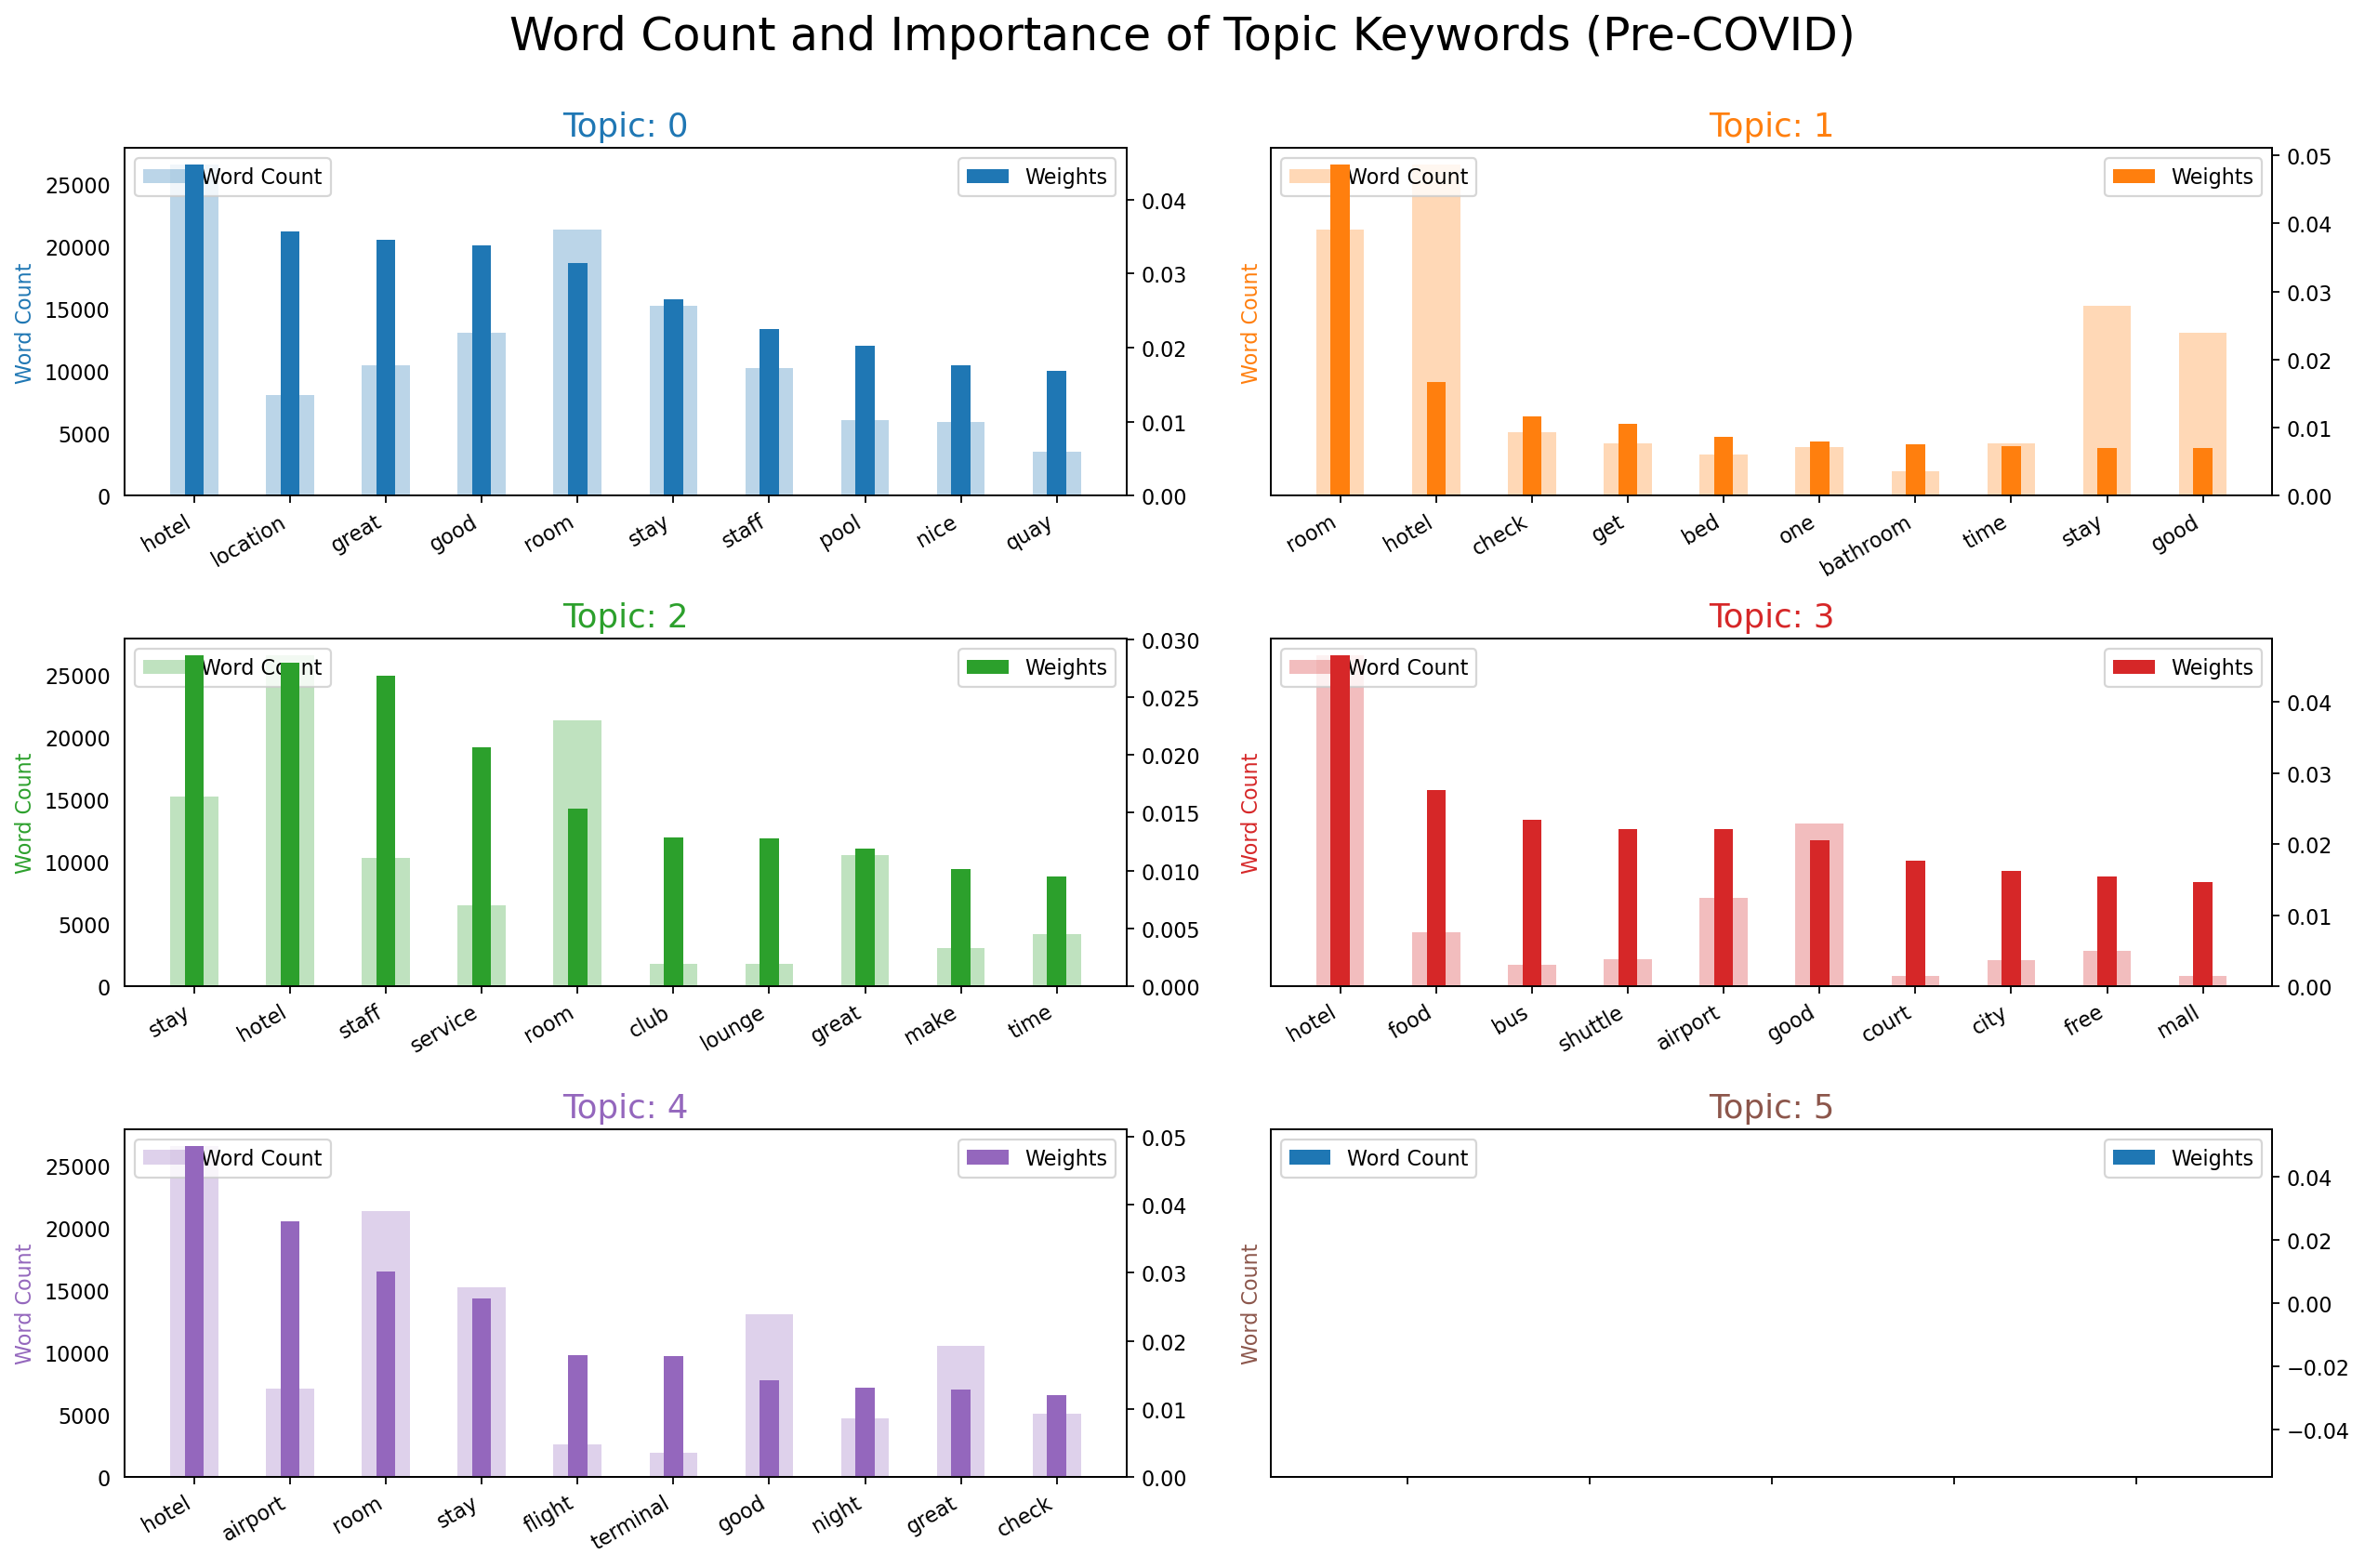

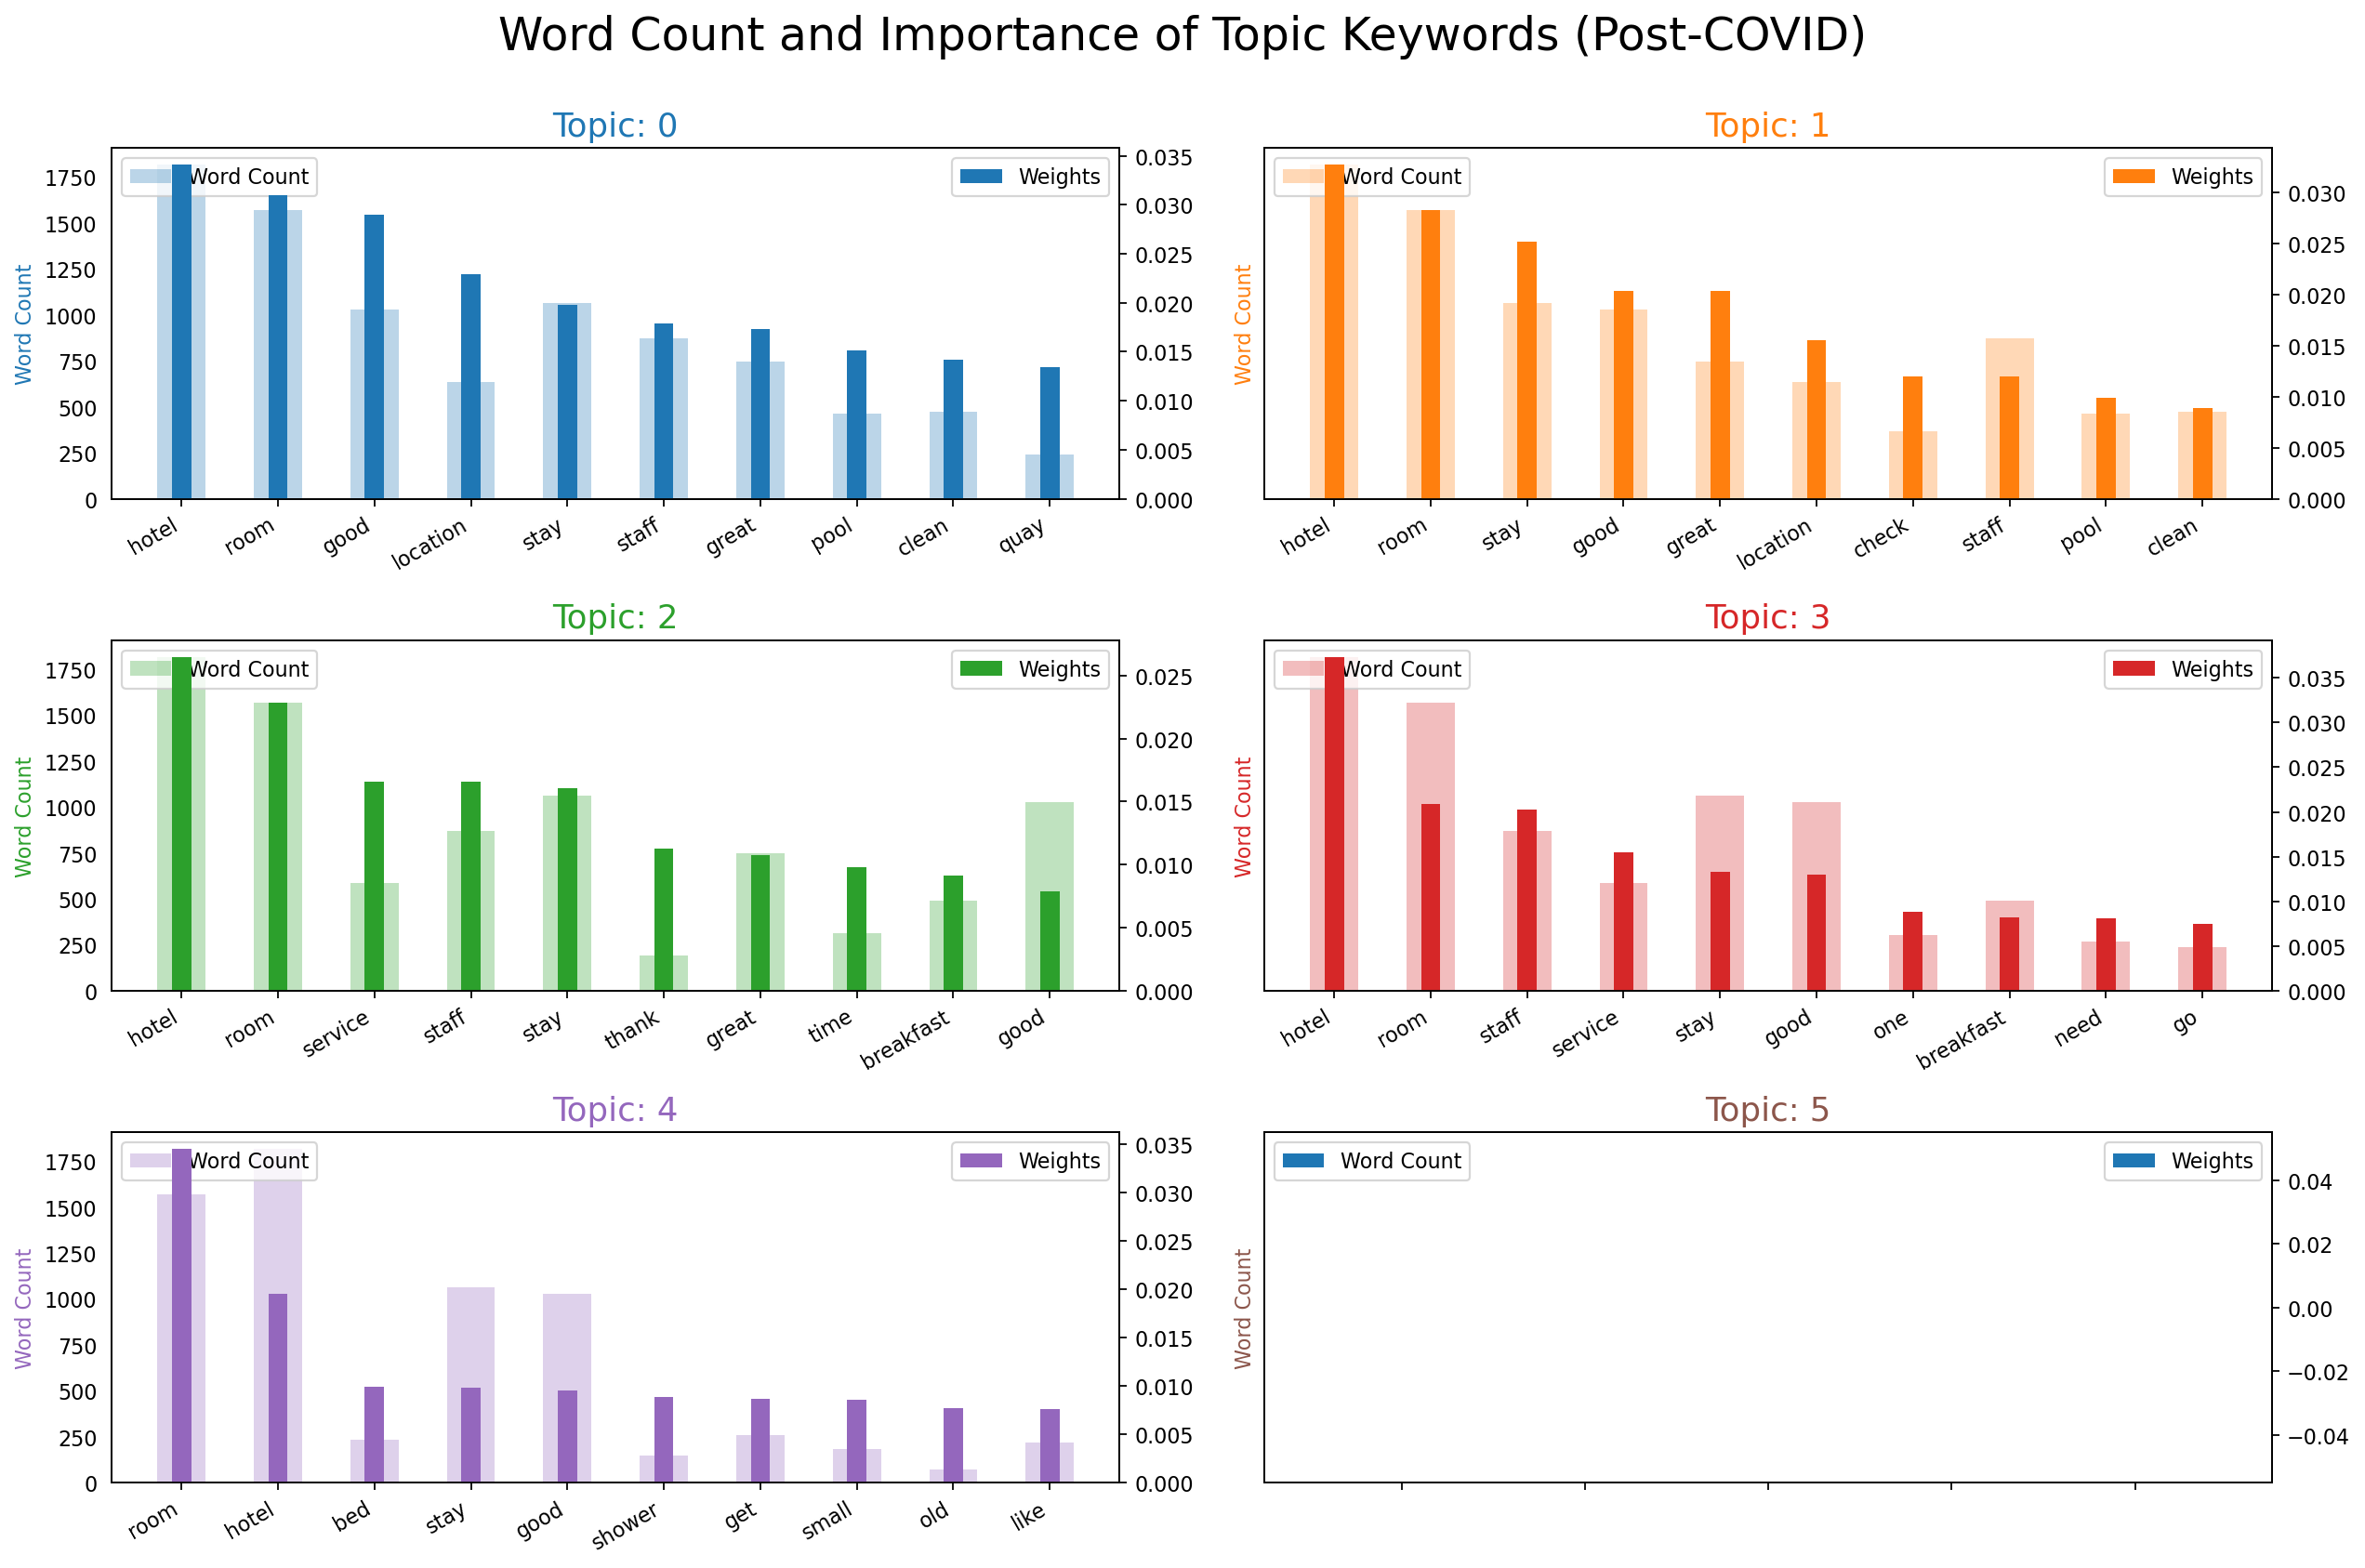

In [17]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

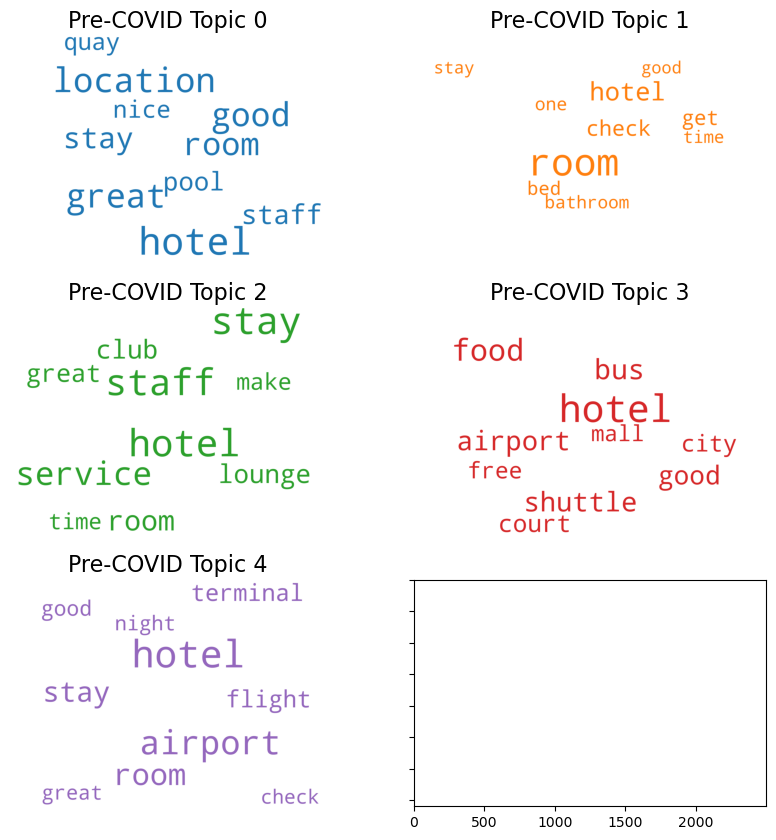

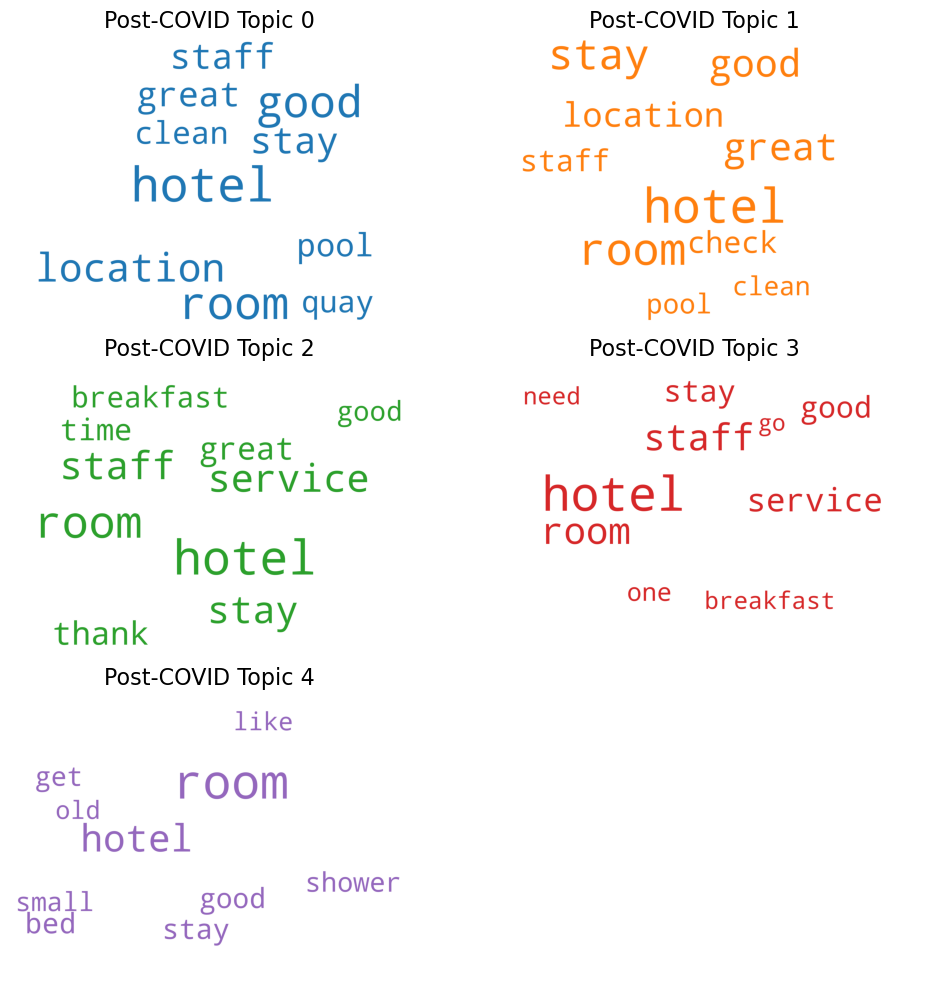

In [19]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [20]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [21]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [22]:
clean_precovid = df_precovid['lem_review'].apply(preprocess)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['lem_review'].apply(preprocess)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [23]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [24]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [25]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [26]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

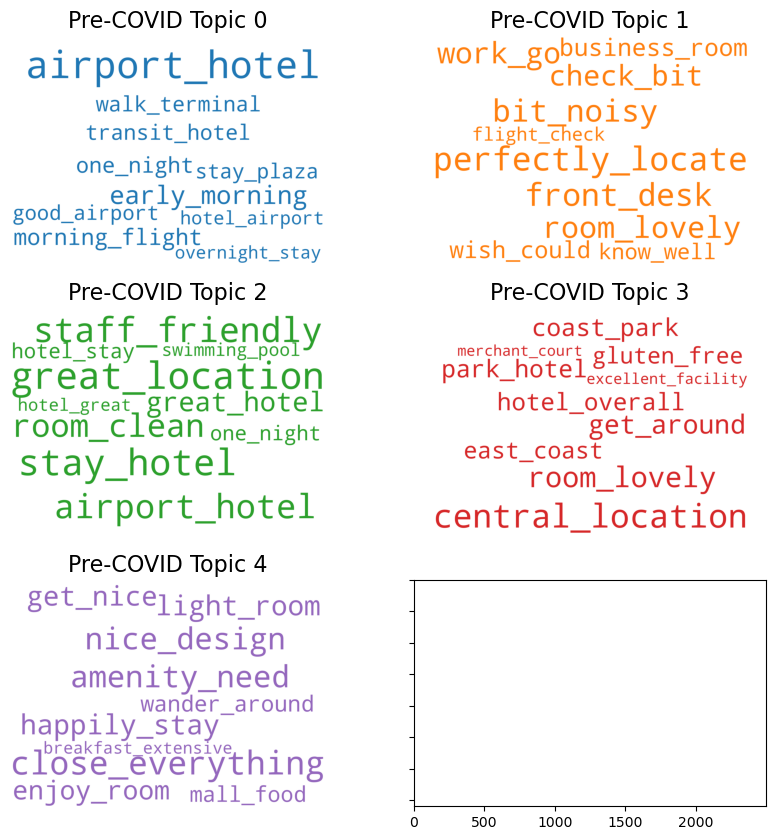

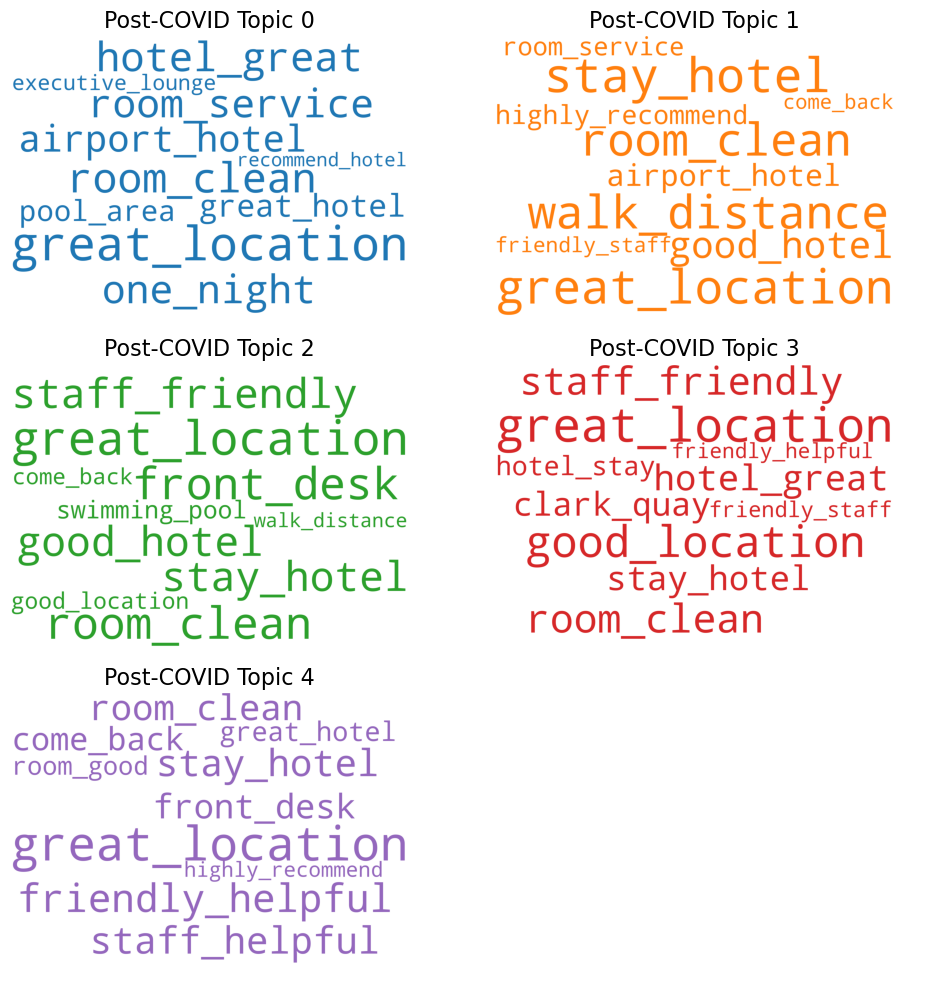

In [27]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [29]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)
